In [ ]:
from google.colab import drive
drive.mount('/content/drive')
pollution_df = pd.read_csv("/content/drive/MyDrive/pollution_2000_2023.csv")
weather_df = pd.read_csv("/content/drive/MyDrive/USA_HistoricalWeather_State.csv")

In [5]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots



# -----------------------------
# Preprocess and Rename Columns for Consistency
# -----------------------------
# In the weather dataset, the state column is named "state"; rename it to "State"
weather_df.rename(columns={'state': 'State'}, inplace=True)

# -----------------------------
# Aggregate Data at the State Level
# -----------------------------
# For pollution, group by State and compute the mean for numeric columns only.
pollution_state = pollution_df.groupby("State", as_index=False).mean(numeric_only=True)

# For weather, group by State and compute the mean for numeric columns only.
weather_state = weather_df.groupby("State", as_index=False).mean(numeric_only=True)

# Merge the two datasets on the "State" column.
merged_df = pd.merge(pollution_state, weather_state, on="State", how="inner")

# -----------------------------
# Compute Combined Weather Metric
# -----------------------------
# Compute an overall average temperature from the seasonal temperature columns.
# (Assumes these columns exist: avg_temp_spr, avg_temp_sum, avg_temp_fall, avg_temp_wint)
merged_df['avg_temp_mean'] = merged_df[['avg_temp_spr', 'avg_temp_sum', 'avg_temp_fall', 'avg_temp_wint']].mean(axis=1)

# -----------------------------
# Visualization 1: Scatter Plot
# -----------------------------
# This scatter plot shows the relationship between the computed average temperature and the average NO₂ level.
fig_scatter = px.scatter(
    merged_df,
    x='avg_temp_mean',
    y='NO2 Mean',
    text='State',
    labels={
        'avg_temp_mean': 'Average Temperature (°F)',
        'NO2 Mean': 'Average NO₂ Level'
    },
    title='Relationship between Average Temperature and NO₂ Levels by State'
)
fig_scatter.update_traces(textposition='top center')
fig_scatter.show()

# -----------------------------
# Visualization 2: Dual-Axis Chart
# -----------------------------
# Create a dual-axis chart with a bar chart for NO₂ levels and a line plot for average temperature.
fig_dual = make_subplots(specs=[[{"secondary_y": True}]])
fig_dual.add_trace(
    go.Bar(x=merged_df['State'], y=merged_df['NO2 Mean'], name='NO₂ Mean'),
    secondary_y=False
)
fig_dual.add_trace(
    go.Scatter(x=merged_df['State'], y=merged_df['avg_temp_mean'], name='Average Temperature', mode='lines+markers'),
    secondary_y=True
)
fig_dual.update_layout(title_text="NO₂ Levels and Average Temperature by State (2000-2023)")
fig_dual.update_yaxes(title_text="Average NO₂ Level", secondary_y=False)
fig_dual.update_yaxes(title_text="Average Temperature (°F)", secondary_y=True)
fig_dual.show()


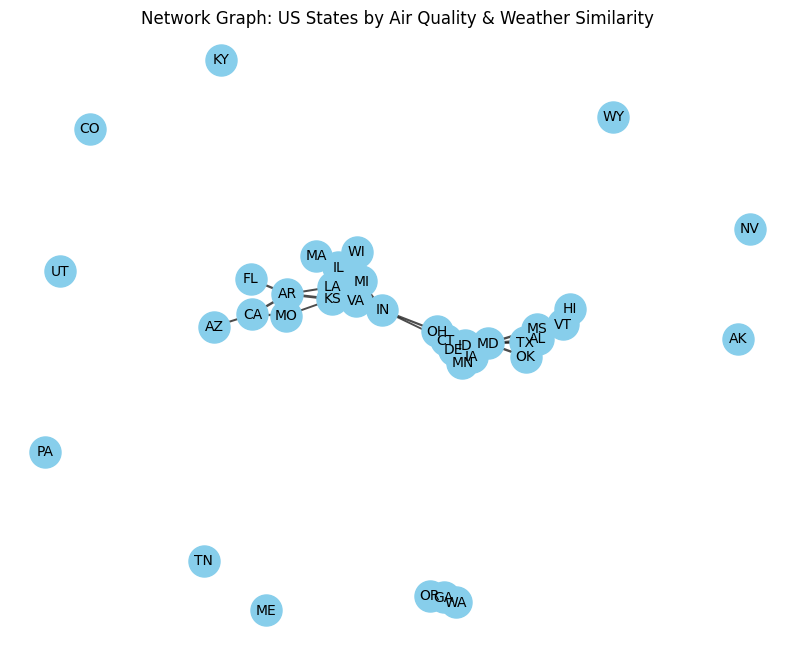

In [8]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from itertools import combinations
from sklearn.preprocessing import StandardScaler
import plotly.express as px

# ---------------------------------------------------
# 1. Prepare a Dictionary to Map Full State Names to Abbreviations
# ---------------------------------------------------
us_state_abbrev = {
    'Alabama': 'AL', 'Alaska': 'AK', 'Arizona': 'AZ', 'Arkansas': 'AR',
    'California': 'CA', 'Colorado': 'CO', 'Connecticut': 'CT', 'Delaware': 'DE',
    'District of Columbia': 'DC', 'Florida': 'FL', 'Georgia': 'GA',
    'Hawaii': 'HI', 'Idaho': 'ID', 'Illinois': 'IL', 'Indiana': 'IN',
    'Iowa': 'IA', 'Kansas': 'KS', 'Kentucky': 'KY', 'Louisiana': 'LA',
    'Maine': 'ME', 'Maryland': 'MD', 'Massachusetts': 'MA', 'Michigan': 'MI',
    'Minnesota': 'MN', 'Mississippi': 'MS', 'Missouri': 'MO', 'Montana': 'MT',
    'Nebraska': 'NE', 'Nevada': 'NV', 'New Hampshire': 'NH', 'New Jersey': 'NJ',
    'New Mexico': 'NM', 'New York': 'NY', 'North Carolina': 'NC',
    'North Dakota': 'ND', 'Ohio': 'OH', 'Oklahoma': 'OK', 'Oregon': 'OR',
    'Pennsylvania': 'PA', 'Rhode Island': 'RI', 'South Carolina': 'SC',
    'South Dakota': 'SD', 'Tennessee': 'TN', 'Texas': 'TX', 'Utah': 'UT',
    'Vermont': 'VT', 'Virginia': 'VA', 'Washington': 'WA', 'West Virginia': 'WV',
    'Wisconsin': 'WI', 'Wyoming': 'WY'
}

# ---------------------------------------------------
# 2. Load and Merge the Datasets
# ---------------------------------------------------


# If your weather file uses 'state' (lowercase) as the column, rename it
weather_df.rename(columns={'state': 'State'}, inplace=True)

# Aggregate both by State (if needed). Otherwise, if they are already at state-level, skip.
pollution_state = pollution_df.groupby("State", as_index=False).mean(numeric_only=True)
weather_state = weather_df.groupby("State", as_index=False).mean(numeric_only=True)

merged_df = pd.merge(pollution_state, weather_state, on="State", how="inner")

# ---------------------------------------------------
# 3. Compute an Average Temperature Column
# ---------------------------------------------------
# If your weather dataset includes these columns, adjust as needed
merged_df["avg_temp_mean"] = merged_df[[
    "avg_temp_spr", "avg_temp_sum", "avg_temp_fall", "avg_temp_wint"
]].mean(axis=1)

# ---------------------------------------------------
# 4. Convert Full State Names to Abbreviations
# ---------------------------------------------------
# If your "State" column already has abbreviations, you can skip this step.
merged_df["State_Abbrev"] = merged_df["State"].map(us_state_abbrev)

# Drop rows where the abbreviation was not found (if any)
merged_df.dropna(subset=["State_Abbrev"], inplace=True)

# ---------------------------------------------------
# 5. Geo Maps Visualization (Choropleth)
# ---------------------------------------------------
# We'll color by NO2 Mean, and show more details (CO Mean, O3 Mean, SO2 Mean, avg_temp_mean) on hover.
fig = px.choropleth(
    merged_df,
    locations="State_Abbrev",         # Use the new abbreviation column
    locationmode="USA-states",        # Recognize them as US states
    color="NO2 Mean",                 # Color scale based on average NO2
    color_continuous_scale="Reds",
    scope="usa",
    title="Average NO₂ Levels by US State (2000-2023)",
    hover_data=["CO Mean", "O3 Mean", "SO2 Mean", "avg_temp_mean"]
)
fig.update_layout(
    margin={"r":0,"t":50,"l":0,"b":0},
    legend_title_text='Avg NO₂ Level'
)
fig.show()

# ---------------------------------------------------
# 6. Network Graph Visualization
# ---------------------------------------------------
# Select features for similarity: four pollution metrics + average temperature
features = ["NO2 Mean", "CO Mean", "O3 Mean", "SO2 Mean", "avg_temp_mean"]

# Drop rows with missing values for these features
merged_df.dropna(subset=features, inplace=True)

# Standardize the features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(merged_df[features])

# Build a NetworkX graph
G = nx.Graph()

# Add each state as a node with attributes
for idx, row in merged_df.iterrows():
    state = row["State_Abbrev"]
    G.add_node(state, features=row[features].to_dict())

# Define a distance threshold to determine edges
threshold = 1.5

# Create edges between states that have similar profiles
from itertools import combinations
import numpy as np

for (i, row1), (j, row2) in combinations(merged_df.iterrows(), 2):
    vec1 = X[i]
    vec2 = X[j]
    dist = np.linalg.norm(vec1 - vec2)
    if dist < threshold:
        G.add_edge(row1["State_Abbrev"], row2["State_Abbrev"], weight=1 / (dist + 1e-5))

# Draw the network graph
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G, seed=42)
edges = G.edges()
weights = [G[u][v]["weight"] for u, v in edges]

nx.draw_networkx_nodes(G, pos, node_size=500, node_color="skyblue")
nx.draw_networkx_edges(G, pos, width=[w * 2 for w in weights], alpha=0.7)
nx.draw_networkx_labels(G, pos, font_size=10)
plt.title("Network Graph: US States by Air Quality & Weather Similarity")
plt.axis("off")
plt.show()